In [12]:
import os
import sys
import uproot
import uproot_methods
import numpy as np
import time

# jupyter nbextension install --py  widgetsnbextension --user
# jupyter nbextension enable --py  widgetsnbextension --user

sys.path.insert(0,'/home/users/{}/.local/lib/python2.7/site-packages/'.format(os.getenv("USER")))
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd

from tqdm import tqdm

print mpl.__version__

# keep at end or else syspath hack is bypassed
%matplotlib inline

2.2.0


In [13]:
def get_object(t, x, year=2016, params={}):
    pt,eta,phi,mass = t.arrays([x+"_pt",x+"_eta",x+"_phi",x+"_mass"], outputtype=tuple, **params)
    obj = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        pt,eta,phi,mass
            )
    if x == "Jet":
        bwp = {2016: 0.6324, 2017: 0.4941, 2018: 0.4184}[year]
        obj["isbtag"] = (t[x+"_btagDeepB"].array(**params) > bwp)
        obj["isgood"] = ((t[x+"_jetId"].array(**params) >> 2) > 0) & (t[x+"_cleanmask"].array(**params) > 0) & (np.abs(obj.eta) < 2.5) & (obj.pt > 25.)
    elif x == "Electron":
        obj["istight"] = (t[x+"_mvaTTH"].array(**params)) > 0.75
#         obj["istight"] = (t[x+"_mvaFall17V2Iso_WP90"].array(**params))
        obj["charge"] = (t[x+"_charge"].array(**params))
    elif x == "Muon":
        obj["istight"] = (t[x+"_mvaTTH"].array(**params)) > 0.75
#         obj["istight"] = (t[x+"_mediumId"].array(**params)) & (t[x+"_pfRelIso04_all"] < 0.3)
        obj["charge"] = (t[x+"_charge"].array(**params))
#         obj[""]
    return obj

In [14]:
# filter(lambda x:"Electron_" in x,t.keys())
# filter(lambda x:"Muon_" in x,t.keys())
# filter(lambda x:"MET_" in x,t.keys())

In [15]:

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(4)
cache = uproot.cache.ThreadSafeArrayCache(4*1024**3)
# cache = None

In [16]:


def get_df(fname,xsec=1,year=2016):
    t0 = time.time()
    t = uproot.open(fname)["Events"]
    params = dict(entrystop=300000,executor=executor,cache=cache)
    jets = get_object(t,"Jet",params=params,year=year)
    nevents = len(jets)
    jets = jets[jets["isgood"]]
    btags = jets[jets["isbtag"]]
    electrons = get_object(t,"Electron",params=params)
    electrons = electrons[electrons["istight"]]
    muons = get_object(t,"Muon",params=params)
    muons = muons[muons["istight"]]
    
    ht = jets.pt.sum()
    htb = btags.pt.sum()

    bb = btags.distincts()
    mbb = (bb.i0 + bb.i1).mass
#     print mbb
    bestmbb = mbb[np.abs(mbb-125.).argmin()].min()
    bestmbb[~np.isfinite(bestmbb)] = -1.
    # -1 for events that don't have 2 btags at least
    
    jj = jets.distincts()
    maxmjj = (jj.i0+jj.i1).mass.max()
    
    ee = electrons.distincts()
    maxmee = (ee.i0+ee.i1).mass.max()
    mm = muons.distincts()
    maxmmm = (mm.i0+mm.i1).mass.max()
    maxmll = np.maximum(maxmee,maxmmm)
    maxmll[~np.isfinite(maxmll)] = -1.
    
    forwardeta = np.abs(jets.eta).max()
    ptjet1 = jets.pt.max()
    ptjet2 = jets.pt[jets.pt != jets.pt.max()].max()
    ptjet1[~np.isfinite(ptjet1)] = -1.
    ptjet2[~np.isfinite(ptjet2)] = -1.

    met,metphi = t.arrays(["MET_pt","MET_phi"],outputtype=tuple,**params)
    
    nleps = (electrons.counts + muons.counts)
    njets = jets.counts
    nbtags = btags.counts
    
    ptlep1 = np.maximum(
        (electrons.pt).max(),
        (muons.pt).max(),
    )
    ptlep1[~np.isfinite(ptlep1)] = -1
    dphimetlep1 = np.minimum(
        ((electrons.phi - metphi + np.pi)%(2*np.pi)-np.pi).min(),
        ((muons.phi - metphi + np.pi)%(2*np.pi)-np.pi).min()
    )
    dphimetlep1[~np.isfinite(dphimetlep1)] = -999.
    mtlep1 = ((2.*ptlep1*met)*(1-np.cos(dphimetlep1)))**.5
    mtlep1[~np.isfinite(mtlep1)] = -1
#     (self.phi - other.phi + math.pi) % (2*math.pi) - math.pi

    lumi = {2016: 35.9, 2017: 41.5, 2018: 59.7}[year]
    weight = (met*0.0)+lumi*xsec/nevents*1000.

    t1 = time.time()
    print "{} events in {:.1f}s ({:.1f}kHz)".format(len(met),t1-t0,0.001*len(met)/(t1-t0))

    df = pd.DataFrame(
        np.c_[
            nleps,njets,nbtags,
            bestmbb,
            met,dphimetlep1,
            ptlep1,mtlep1,
            ptjet1,ptjet2,
            maxmjj,
            maxmll,
            ht,htb,
            forwardeta,
            weight,
        ],columns=[
            "nleps","njets","nbtags",
            "bestmbb",
            "met","dphimetlep1",
            "ptlep1","mtlep1",
            "ptjet1","ptjet2",
            "maxmjj",
            "maxmll",
            "ht","htb",
            "forwardeta",
            "weight",
        ])
    return df

# get_df("data/THQ_4f_Hincl_13TeV_madgraph_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/09293AA4-3F21-484C-A456-A094E96EC962.root",)

In [17]:
d_xsecs = {
"thq":  0.0748, # https://arxiv.org/pdf/1504.00611.pdf
"thw":  0.016*0.0748/0.0718, # eq 16/10 of https://arxiv.org/pdf/1211.0499.pdf
"tt":  831.8,
"tthnonbb": 0.2710,
"tthbb": 0.2044,
"ttw": 0.610,
"ttz": 0.840,
}

In [18]:
d_fnames = {
"thq": "data/THQ_4f_Hincl_13TeV_madgraph_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/09293AA4-3F21-484C-A456-A094E96EC962.root",
"thw": "data/THW_5f_Hincl_13TeV_madgraph_pythia8__RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_102X_mc2017_realistic_v6-v1/35C99292-4F4F-3B4E-BFFA-D2ADC6A19B69.root",
"tt": "data/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8__RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_102X_mc2017_realistic_v6-v1/262A894B-282D-D04E-8CFA-97C2CCCC27E9.root",
"tthnonbb": "data/ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8__RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_new_pmx_102X_mc2017_realistic_v6-v1/046E6B5B-D890-3749-B1C6-710B135770F5.root",
"tthbb": "data/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8__RunIIAutumn18NanoAOD-102X_upgrade2018_realistic_v15-v3/6ACADA22-5B5E-E94A-8D61-54A113076F69.root",
"ttw": "data/ttWJets_TuneCP5_13TeV_madgraphMLM_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16_ext1-v1/02824CAB-E745-2D4B-B00E-B492F93F7456.root",
"ttz": "data/ttZJets_TuneCP5_13TeV_madgraphMLM_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16_ext1-v1/2245EBBB-6E09-194E-9DA8-B0B203BE69B8.root",
}
# f = uproot.open("data/THQ_4f_Hincl_13TeV_madgraph_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/09293AA4-3F21-484C-A456-A094E96EC962.root")
# fname = "data/THW_5f_Hincl_13TeV_madgraph_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/5E74BF12-A9A4-2545-AED9-AE99F8B50DF4.root"
# f = uproot.open("data/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8__RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_102X_mc2017_realistic_v6-v1/262A894B-282D-D04E-8CFA-97C2CCCC27E9.root")
# f = uproot.open("data/ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8__RunIIFall17NanoAODv4-PU2017_12Apr2018_Nano14Dec2018_new_pmx_102X_mc2017_realistic_v6-v1/046E6B5B-D890-3749-B1C6-710B135770F5.root")
# f = uproot.open("data/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8__RunIIAutumn18NanoAOD-102X_upgrade2018_realistic_v15-v3/6ACADA22-5B5E-E94A-8D61-54A113076F69.root")
# f = uproot.open("data/ttWJets_13TeV_madgraphMLM__RunIISummer16NanoAODv4-Nano14Dec2018_102X_mcRun2_asymptotic_v6-v1/2FCB757F-3432-B54A-AABC-D06AB770E189.root")
# print f.keys()
# t = f["Events"]

# print t["Jet_pt"]
dfs = {}
for proc,fname in d_fnames.items():
    print proc
    year = 2016
    if "Fall17" in fname: year = 2017
    if "Autumn18" in fname: year = 2018
    dfs[proc] = get_df(fname,xsec=d_xsecs[proc],year=year)


ttz


/home/users/namin/.local/lib/python2.7/site-packages/awkward/array/jagged.py:933: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-elfike2/lib/python2.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in sqrt


300000 events in 17.7s (17.0kHz)
thw
300000 events in 12.1s (24.8kHz)
tt
300000 events in 12.2s (24.5kHz)
ttw
300000 events in 14.1s (21.2kHz)
thq
179999 events in 6.0s (29.9kHz)
tthbb
162000 events in 6.7s (24.1kHz)
tthnonbb
300000 events in 14.9s (20.2kHz)


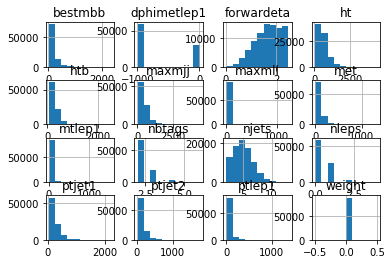

In [19]:
import corner
# dfs["thq"].bestmbb
# df = dfs["thq"]
df = dfs["thw"]
# corner.corner(df[df.nbtags>=2],smooth=2,smooth1d=0);
df[df.nbtags>=2].hist();

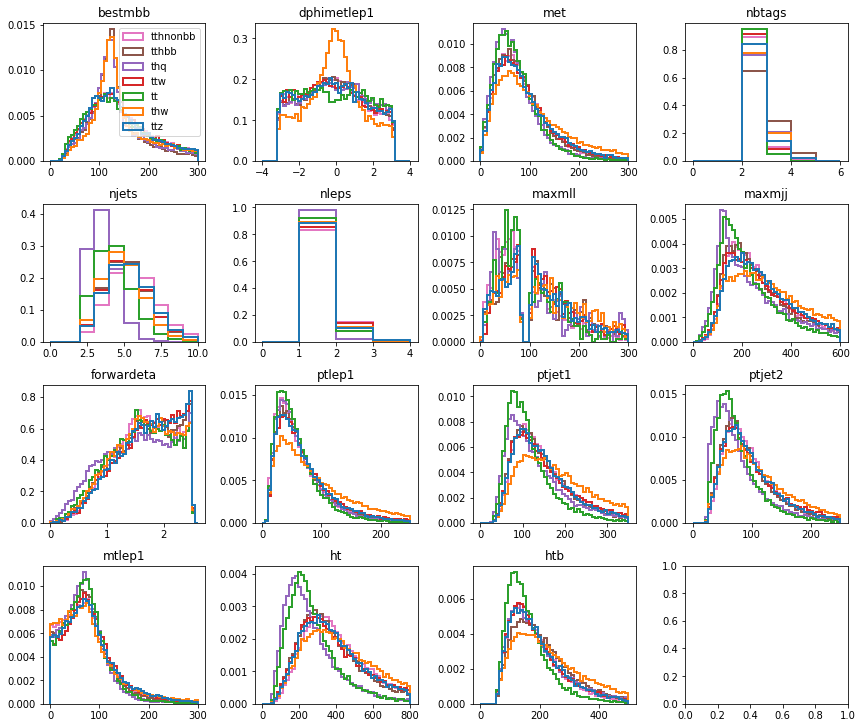

In [20]:
fig,axs = plt.subplots(4,4,figsize=(12,10),constrained_layout=True)
axs = (ax for ax in axs.flat)
for ivar,(var,bins) in enumerate([
    ["bestmbb",np.linspace(0,300,50)],
    ["dphimetlep1",np.linspace(-4,4,50)],
    ["met",np.linspace(0,300,50)],
    ["nbtags",np.linspace(0,6,7)],
    ["njets",np.linspace(0,10,11)],
    ["nleps",np.linspace(0,4,5)],
    ["maxmll",np.linspace(0,300,50)],
    ["maxmjj",np.linspace(0,600,50)],
    ["forwardeta",np.linspace(0,2.6,50)],
    ["ptlep1",np.linspace(0,250,50)],
    ["ptjet1",np.linspace(0,350,50)],
    ["ptjet2",np.linspace(0,250,50)],
    ["mtlep1",np.linspace(0,300,50)],
    ["ht",np.linspace(0,800,50)],
    ["htb",np.linspace(0,500,50)],
]):
    ax = next(axs)
#     procs = list(set(dfs.keys())-set(["tt"]))
    procs = dfs.keys()
    def sel(df):
        return (df.nbtags>=2) & (df.njets>=2) & (df.nleps >= 1) & (np.abs(df.maxmll-91.2)>10.)
    vals = [dfs[k][sel(dfs[k])][var] for k in procs]
    weights = [dfs[k][sel(dfs[k])]["weight"] for k in procs]
#     ax.hist(vals,bins=bins,weights=weights,stacked=False,alpha=1,histtype="step",label=procs,density=False,lw=2);
    ax.hist(vals,bins=bins,weights=weights,stacked=False,alpha=1,histtype="step",label=procs,density=True,lw=2);
    ax.set_title(var);
    if ivar == 0: ax.legend();

In [21]:
patt = "data/THQ_4f_Hincl_13TeV_madgraph_pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/*.root"
# patt = "data/ttHToNonbb_M125_TuneCP5_13TeV-powheg-pythia8__RunIIAutumn18NanoAODv4-Nano14Dec2018_102X_upgrade2018_realistic_v16-v1/*.root"
t0 = time.time()
ttmp = time.time()
nevts = 0
dfs = []

from tqdm import tqdm_notebook

pbar = tqdm_notebook(total=10e6, unit_scale=True, unit="evt")
for branches in uproot.iterate(patt,"Events",
                    [
                        "Jet_pt", "Jet_eta", "Jet_phi","Jet_mass",
                        "Electron_pt", "Electron_eta", "Electron_phi","Electron_mass",
                        "Muon_pt", "Muon_eta", "Muon_phi","Muon_mass",
                        "MET_pt", "MET_phi",
                    ],entrysteps=200000,outputtype=dict,
#                                cache=cache,
#                                executor=executor,
#                         executor = concurrent.futures.ThreadPoolExecutor(32)
                        executor = concurrent.futures.ThreadPoolExecutor(4),
                   ):
    t1 = time.time()
    
    pts = branches["Jet_pt"]
    nevts += len(pts)
#     print "{} events in {:.1f}s ({:.1f}kHz)".format(len(pts),t1-ttmp,0.001*len(pts)/(t1-ttmp))
    
    df = pd.DataFrame(pts.sum(),columns=["ht"])
    dfs.append(df)
    pbar.update(len(pts))
    
    ttmp = time.time()
    
df = pd.concat(dfs)

pbar.close()
# print df
    
    
print "TOTAL:"
print "{} events in {:.1f}s ({:.1f}kHz)".format(nevts,ttmp-t0,0.001*nevts/(ttmp-t0))

# print dir(it)
# for x in it:
#     print "HERE"
#     print x
#     break




TOTAL:
1029999 events in 22.3s (46.1kHz)
